<a href="https://colab.research.google.com/github/Alevtina529/test/blob/main/finn_project_skf_HEC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#1. Постановка задачи

Прогноз расхода энергии по временным рядам

С их помощью можно построить модель временных рядов, чтобы прогнозировать энергетический расход. Кроме того, эти данные пригодятся, чтобы выявить тенденции расходов по времени суток, праздникам и более длительным срокам.

О наборе данных

Почасовые данные о энергопотреблении

Данные о почасовом энергопотреблении указаны в мегаваттах (МВт).

# Знакомство с данными, базовый анализ и расширение данных


In [1]:
# Заранее импортируем модули, которые нам понадобятся для решения задачи:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_selection
sns.color_palette()

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
cvs='/content/drive/MyDrive/Colab/dataset/Finn/est_hourly.paruqet'
df = pd.read_parquet(cvs)
df

,AEP,COMED,DAYTON,DEOK,DOM,DUQ,EKPC,FE,NI,PJME,PJMW,PJM_Load
Datetime,,,,,,,,,,,,
1998-12-31 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,29309.0
1998-12-31 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28236.0
1998-12-31 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27692.0
1998-12-31 04:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27596.0
1998-12-31 05:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27888.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2018-01-01 20:00:00,21089.0,13858.0,2732.0,4426.0,18418.0,1962.0,2866.0,9378.0,NaN,44284.0,8401.0,NaN
2018-01-01 21:00:00,20999.0,13758.0,2724.0,4419.0,18567.0,1940.0,2846.0,9255.0,NaN,43751.0,8373.0,NaN
2018-01-01 22:00:00,20820.0,13627.0,2664.0,4355.0,18307.0,1891.0,2883.0,9044.0,NaN,42402.0,8238.0,NaN


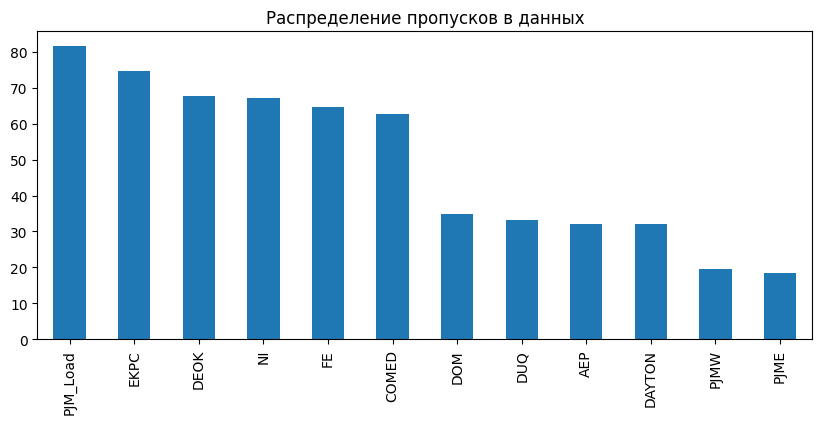

In [4]:
# названия столбцов, где число пропусков больше 0
cols_null_percent = df.isnull().mean() * 100
cols_with_null = cols_null_percent[cols_null_percent>0].sort_values(ascending=False)
cols_with_null.plot(
    kind='bar',
    figsize=(10, 4),
    title='Распределение пропусков в данных'
);

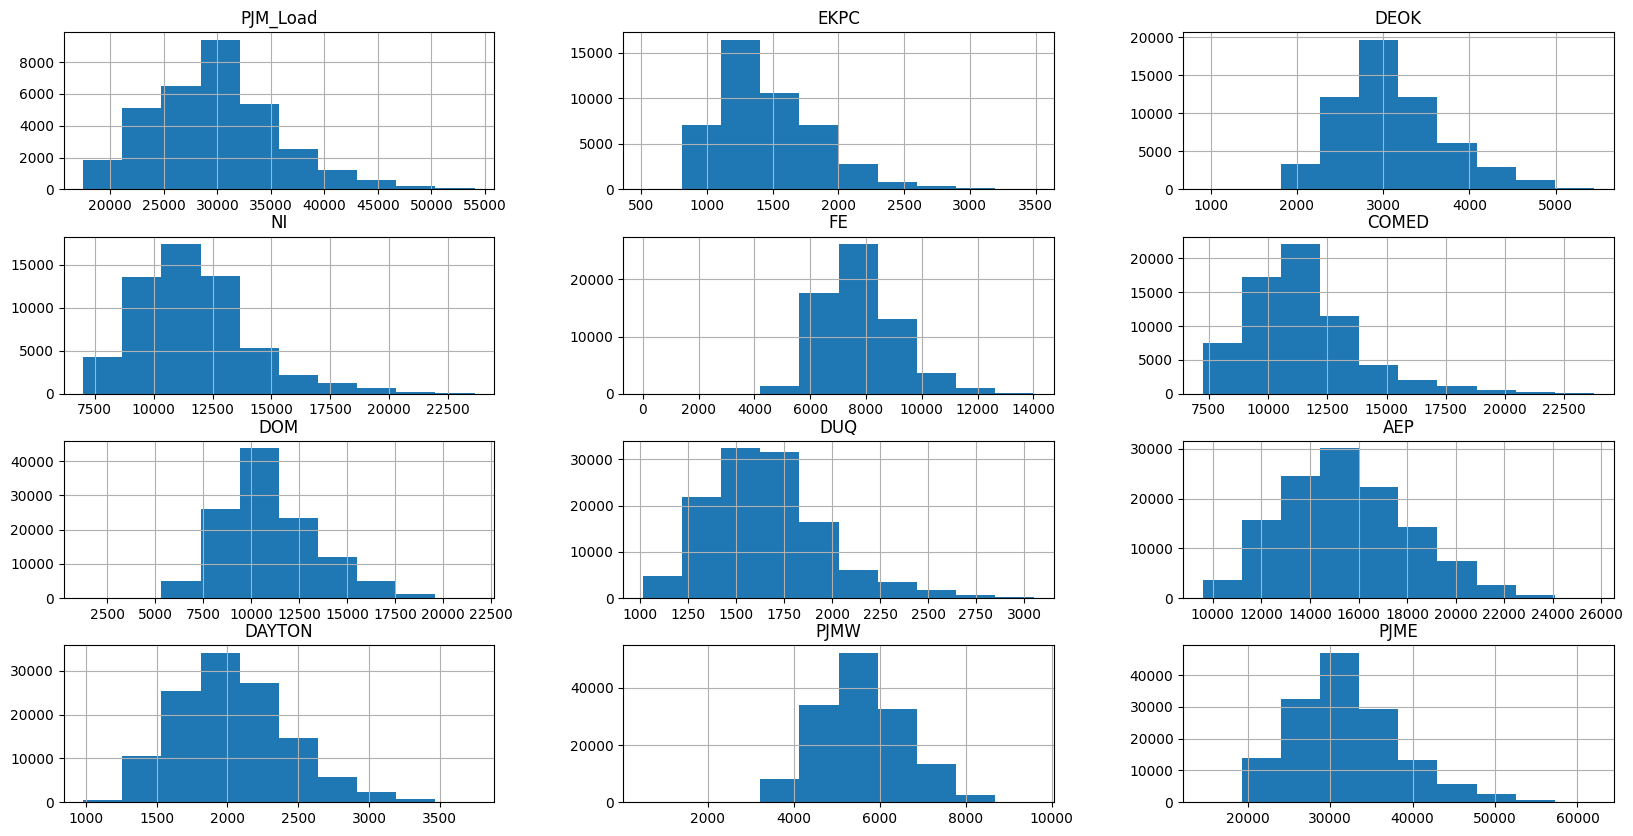

In [5]:
cols = cols_with_null.index
df[cols].hist(figsize=(20, 10));

In [6]:
cols_with_null

PJM_Load    81.546263
EKPC        74.568893
DEOK        67.610035
NI          67.211184
FE          64.729443
COMED       62.697041
DOM         34.821218
DUQ         33.206180
AEP         31.969236
DAYTON      31.968114
PJMW        19.665436
PJME        18.453737
dtype: float64

In [7]:
#создаем копию исходной таблицы
fill_data = df.copy()
#создаем словарь имя столбца: число(признак) на который надо заменить пропуски
values = {
    'PJM_Load': fill_data['PJM_Load'].median(),
    'EKPC': fill_data['EKPC'].median(),
    'DEOK': fill_data['DEOK'].median(),
    'NI': fill_data['NI'].median(),
    'FE': fill_data['FE'].median(),
    'DOM': fill_data['DOM'].median(),
    'COMED': fill_data['COMED'].median(),
    'DUQ': fill_data['DUQ'].median(),
    'AEP': fill_data['AEP'].median(),
    'DAYTON': fill_data['DAYTON'].median(),
    'PJMW': fill_data['PJMW'].median(),
    'PJME': fill_data['PJME'].median()

}
#заполняем пропуски в соответствии с заявленным словарем
fill_data = fill_data.fillna(values)
#выводим результирующую долю пропусков
fill_data.isnull().mean()

AEP         0.0
COMED       0.0
DAYTON      0.0
DEOK        0.0
DOM         0.0
DUQ         0.0
EKPC        0.0
FE          0.0
NI          0.0
PJME        0.0
PJMW        0.0
PJM_Load    0.0
dtype: float64

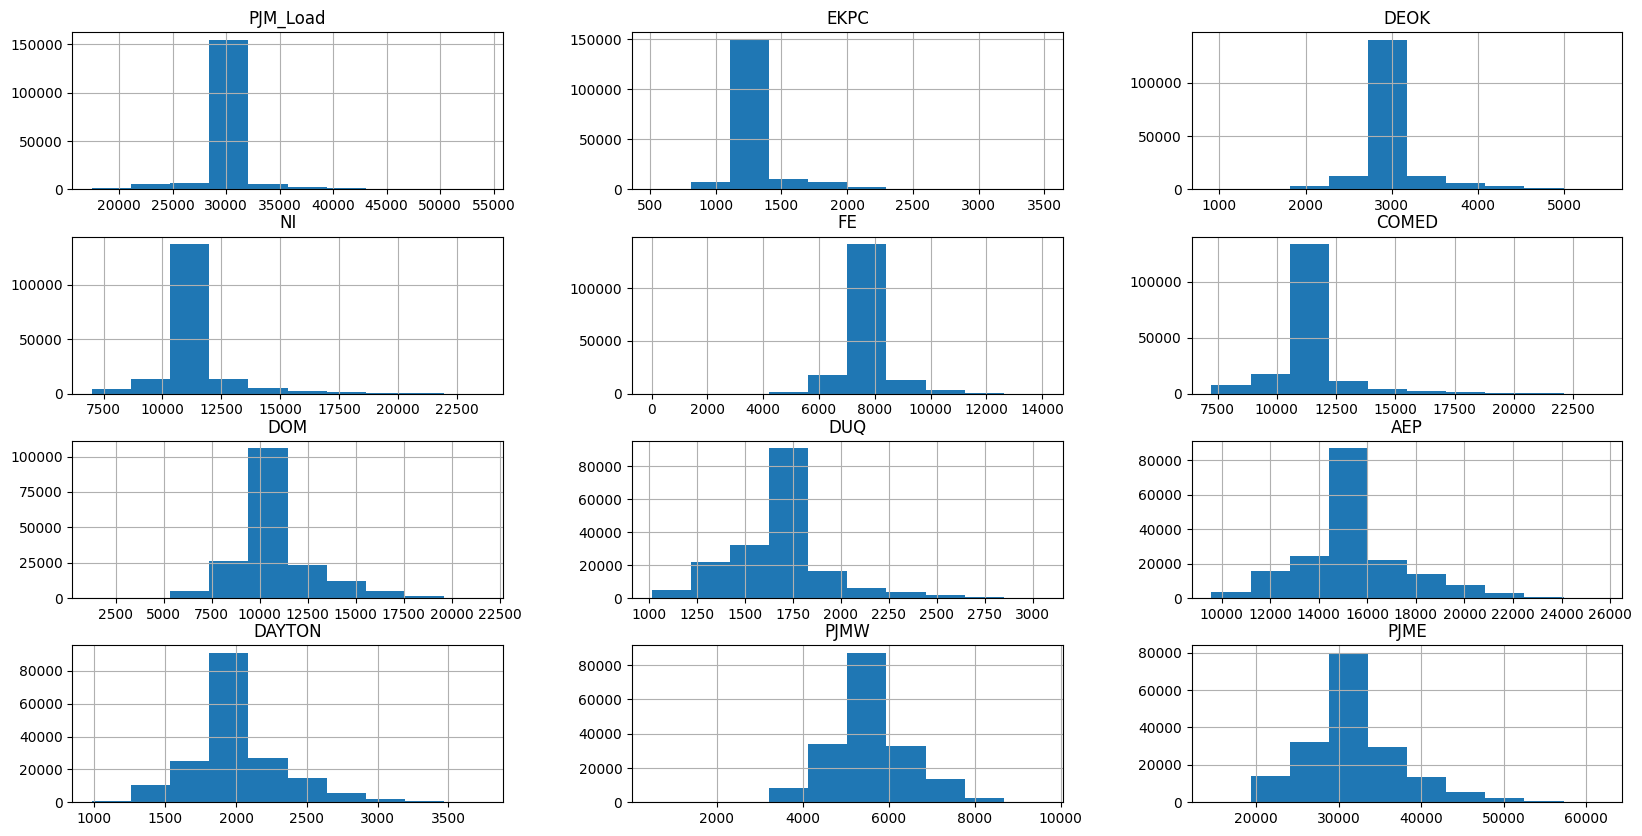

In [8]:
cols = cols_with_null.index
fill_data[cols].hist(figsize=(20, 10));

In [9]:
fill_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 178262 entries, 1998-12-31 01:00:00 to 2018-01-02 00:00:00
Data columns (total 12 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   AEP       178262 non-null  float64
 1   COMED     178262 non-null  float64
 2   DAYTON    178262 non-null  float64
 3   DEOK      178262 non-null  float64
 4   DOM       178262 non-null  float64
 5   DUQ       178262 non-null  float64
 6   EKPC      178262 non-null  float64
 7   FE        178262 non-null  float64
 8   NI        178262 non-null  float64
 9   PJME      178262 non-null  float64
 10  PJMW      178262 non-null  float64
 11  PJM_Load  178262 non-null  float64
dtypes: float64(12)
memory usage: 17.7 MB


<Axes: xlabel='Datetime'>

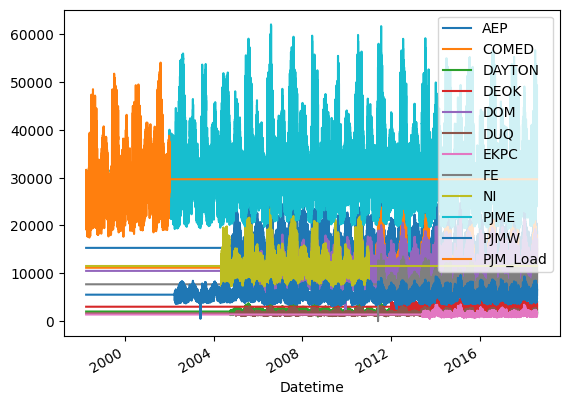

In [10]:
fill_data.plot()

In [ ]:
decomposition = seasonal_decompose(fill_data, model='additive')
decomposition.plot()
pyplot.show() # любуемся результатом

ValueError: ignored

In [42]:
cvs_1='/content/drive/MyDrive/Colab/dataset/Finn/1.csv'
df_1 = pd.read_csv(cvs_1)
df_1

,Datetime,PJMW_MW
0,2002-12-31 01:00:00,5077.0
1,2002-12-31 02:00:00,4939.0
2,2002-12-31 03:00:00,4885.0
3,2002-12-31 04:00:00,4857.0
4,2002-12-31 05:00:00,4930.0
...,...,...
143201,2018-01-01 20:00:00,8401.0
143202,2018-01-01 21:00:00,8373.0
143203,2018-01-01 22:00:00,8238.0
143204,2018-01-01 23:00:00,7958.0


<Axes: >

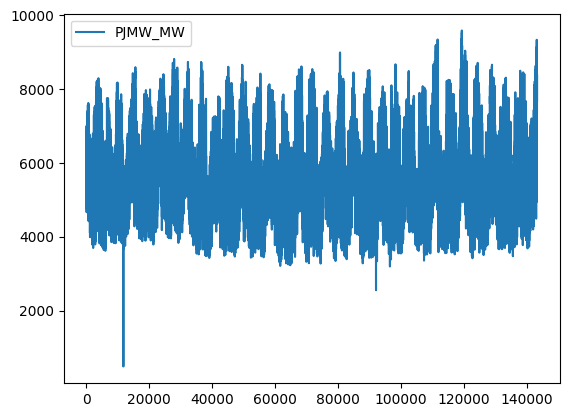

In [43]:
df_1.plot()

In [44]:
import pandas as pd
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from matplotlib import pyplot
import statsmodels.api as sm

from datetime import datetime

Для начала посмотрим на временные рамки, в которых мы работаем с данными.

Переведем признак Datetime в тип данных datetime с форматом год-месяц-день час:минута:секунда (в функции pd.to_datetime() параметр format='%Y-%m-%d %H:%M:%S').

Временные рамки, за которые представлены данные.

In [45]:
df_1['Datetime']=pd.to_datetime(df_1['Datetime'],format='%Y-%m-%d %H:%M:%S')

Реализуйте функцию add_datetime_features(), которая принимает на вход таблицу с данными о поездках (DataFrame) и возвращает ту же таблицу с добавленными в нее 3 столбцами:

pickup_date - дата включения счетчика - начала поездки (без времени);
pickup_hour - час дня включения счетчика;
pickup_day_of_week - наименование дня недели, в который был включен счетчик.

In [46]:
# ваш код здесь
def add_datetime_features(df):
    df['Datetime__date'] = df['Datetime'].dt.date
    return df
display(add_datetime_features(df_1))

,Datetime,PJMW_MW,Datetime__date
0,2002-12-31 01:00:00,5077.0,2002-12-31
1,2002-12-31 02:00:00,4939.0,2002-12-31
2,2002-12-31 03:00:00,4885.0,2002-12-31
3,2002-12-31 04:00:00,4857.0,2002-12-31
4,2002-12-31 05:00:00,4930.0,2002-12-31
...,...,...,...
143201,2018-01-01 20:00:00,8401.0,2018-01-01
143202,2018-01-01 21:00:00,8373.0,2018-01-01
143203,2018-01-01 22:00:00,8238.0,2018-01-01
143204,2018-01-01 23:00:00,7958.0,2018-01-01


In [47]:
df_1 = df_1.drop(['Datetime'], axis = 1)

In [48]:
df_1.set_index('Datetime__date')

,PJMW_MW
Datetime__date,
2002-12-31,5077.0
2002-12-31,4939.0
2002-12-31,4885.0
2002-12-31,4857.0
2002-12-31,4930.0
...,...
2018-01-01,8401.0
2018-01-01,8373.0
2018-01-01,8238.0


In [49]:
df_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143206 entries, 0 to 143205
Data columns (total 2 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   PJMW_MW         143206 non-null  float64
 1   Datetime__date  143206 non-null  object 
dtypes: float64(1), object(1)
memory usage: 2.2+ MB


In [53]:
df_1['Datetime__date']=df_1['Datetime__date'].astype('datetime64')

<ipython-input-53-fe35bb5f538c>:1: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  df_1['Datetime__date']=df_1['Datetime__date'].astype('datetime64')


In [54]:
df_1['Datetime__date'] = pd.to_datetime(df_1['Datetime__date'], dayfirst=True)

In [57]:
df_1

,PJMW_MW,Datetime__date
0,5077.0,2002-12-31
1,4939.0,2002-12-31
2,4885.0,2002-12-31
3,4857.0,2002-12-31
4,4930.0,2002-12-31
...,...,...
143201,8401.0,2018-01-01
143202,8373.0,2018-01-01
143203,8238.0,2018-01-01
143204,7958.0,2018-01-01


In [58]:
df_1.set_index('Datetime__date')

,PJMW_MW
Datetime__date,
2002-12-31,5077.0
2002-12-31,4939.0
2002-12-31,4885.0
2002-12-31,4857.0
2002-12-31,4930.0
...,...
2018-01-01,8401.0
2018-01-01,8373.0
2018-01-01,8238.0


In [59]:
decomposition = seasonal_decompose(df_1, model='additive')
decomposition.plot()
pyplot.show()

TypeError: ignored